In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm, uniform
from pyDOE2 import lhs
import numpy as onp
from astropy.cosmology import Planck13
from astropy.table import Table, vstack
import subprocess
from astropy.constants import L_sun, M_sun
import glob
import pylab as plt

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
def generate_CIGALE_String(vals):
    return onp.array2string(vals, separator=',',formatter={'float_kind':lambda x: "%.4f" % x}).replace('\n','')

In [3]:
alpha=np.array([0.0625, 0.1250, 0.1875, 0.2500,0.3125, 0.3750, 0.4375, 0.5000, 0.5625, 0.6250, 0.6875, 0.7500,0.8125, 0.8750, 0.9375, 1.0000, 1.0625, 1.1250, 1.1875, 1.2500,1.3125, 1.3750, 1.4375, 1.5000, 1.5625, 1.6250, 1.6875, 1.7500, 1.8125, 1.8750, 1.9375, 2.0000, 2.0625, 2.1250, 2.1875, 2.2500,2.3125, 2.3750, 2.4375, 2.5000, 2.5625, 2.6250, 2.6875, 2.7500,2.8125, 2.8750, 2.9375, 3.0000, 3.0625, 3.1250, 3.1875, 3.2500, 3.3125, 3.3750, 3.4375, 3.5000, 3.5625, 3.6250, 3.6875, 3.7500, 3.8125, 3.8750, 3.9375, 4.0000])
alpha=alpha[::4]
#av_bc=onp.arange(0.1,4.0,0.2)
av_bc=[0.1,4.0]
#tau=onp.arange(500,6500,200)
tau=[500,6500]
age=[1000,10001]
z=[0.05,6.5]#10.0**onp.arange(-2.5,0.77,0.1)
#sfr=10.0**onp.arange(-2,4.75,0.25)
sfr=[-2,4.6]
agn_frac=[0,1.0]


In [4]:
parameter_names=np.array(['tau_main','age_main','Av_BC','alpha','fracAGN','redshift'])
parameters={'tau_main':tau,'age_main':age,
                'Av_BC':av_bc,'fracAGN':agn_frac,'redshift':z,'sfr':sfr}

In [5]:
for i,s in enumerate(parameters):
    print(i,s)

0 tau_main
1 age_main
2 Av_BC
3 fracAGN
4 redshift
5 sfr


In [6]:
def sample_params(nsamp,parameters):
    new_param=parameters.copy()
    lhd = lhs(len(parameters), samples=nsamp,criterion='correlation')
    for i,s in enumerate(parameters):
        lhd[:,i]=lhd[:,i]*(parameters[s][1]-parameters[s][0])+parameters[s][0]
        new_param[s]=lhd[:,i]
    new_param['age_main']=np.round(new_param['age_main'])
    new_param['tau_main']=np.round(new_param['tau_main'])
    new_param['sfr']=10.0**new_param['sfr']
    new_param['alpha']=alpha
    return new_param

In [7]:
sample_params(5,parameters)

{'tau_main': array([3800., 5180., 2869., 5381.,  612.]),
 'age_main': array([5298., 2698., 4391., 6785., 9862.]),
 'Av_BC': array([1.7287771 , 0.21802514, 2.59981293, 1.09354032, 3.27472263]),
 'fracAGN': array([0.05450618, 0.9748011 , 0.29862853, 0.72503896, 0.51076031]),
 'redshift': array([5.32345227, 2.82136079, 4.32401895, 2.05595922, 0.37094197]),
 'sfr': array([5.14549956e-01, 5.00087365e+01, 1.45995585e+02, 4.49477446e-02,
        8.06745298e+03]),
 'alpha': array([0.0625, 0.3125, 0.5625, 0.8125, 1.0625, 1.3125, 1.5625, 1.8125,
        2.0625, 2.3125, 2.5625, 2.8125, 3.0625, 3.3125, 3.5625, 3.8125])}

In [ ]:
    col_scale=['F560W','F770W','F1000W','F1130W','1280W','F1500W','F1800W','F2100W','F2550W',' spire_250',' spire_350',' spire_500',' SCUBA450','SCUBA850',' ALMA_band10','ALMA_band9','ALMA_band8','ALMA_band7','ALMA_band6','ALMA_band5','ALMA_band4','ALMA_band3']


In [39]:
def generate_SEDs(parameter_names,parameters_bounds,path_to_cigale,path_to_ini_file,filename='tmp',nbatch=5):
    col_scale=['F560W','F770W','F1000W','F1130W','F1280W','F1500W','F1800W','F2100W','F2550W','spire_250','spire_350','spire_500','SCUBA450','SCUBA850','ALMA_band10','ALMA_band9','ALMA_band8','ALMA_band7','ALMA_band6','ALMA_band5','ALMA_band4','ALMA_band3','dust.luminosity','sfh.sfr','stellar.m_star']

    #col_scale=['omegacam_u', 'omegacam_g','omegacam_r','omegacam_i','omegacam_z', 'irac_i1','spire_250','spire_350','spire_500','dust.luminosity','sfh.sfr','stellar.m_star']
    #loop over batchs
    for b in range(0,nbatch):
        print(b)
        #generate samples of parameters
        parameters=sample_params(3,parameters_bounds)
        #loop over values in redshift (cant sample from prior due to link between redshift and main_age)
        for i,z in enumerate(parameters['redshift']):
            
            #set up boolean for frac to deal with the two fracagn variables in cigale (first one needs to be set to zero)
            fracagn=True
            #copy dictionary of parameters
            parameters_tmp = dict(parameters)
            #add redshift
            parameters_tmp['redshift']=[z]
            #add age_main
            parameters_tmp['age_main']=[np.floor(Planck13.age(z).value*1000.0)]
            
            #open the template cigale file
            fin = open(path_to_cigale+path_to_ini_file)
            #open the standard pcigale ini file to copy edits to
            fout = open(path_to_cigale+"pcigale.ini", "wt")
            #for each line
            for line in fin:
                #check if the line match any parameter names
                ind_line=[param + " =" in line for param in parameter_names]

                if any(ind_line):
                    param=parameter_names[onp.array(ind_line)]
                    #if parameter name is fracAGN check if this is the first 
                    if param[0]=='fracAGN':
                        if fracagn:
                            fout.write(line)
                            fracagn=False
                        else:
                            #otherwise write out parameter values
                            fout.write("   "+param[0]+" = " + ", ".join(['{:.13f}'.format(i) for i in parameters_tmp[param[0]]]) + ' \n')
                            fracagn=True
                    else:
                        fout.write("   "+param[0]+" = " + ", ".join(['{:.13f}'.format(i) for i in parameters_tmp[param[0]]]) + ' \n')
                else:
                    fout.write(line)
                    
            #close files
            fin.close()
            fout.close()
            
            from shutil import copyfile, move, rmtree
            #copy corresponding ini.spec file to standard path
            copyfile(path_to_cigale+path_to_ini_file+".spec",path_to_cigale+"pcigale.ini.spec")
            #run cigale
            p = subprocess.Popen(['pcigale', 'run'], cwd=path_to_cigale)
            p.wait()
            #check if folder already exists
            try:
                rmtree(path_to_cigale+'{}/'.format(filename))
            except(FileNotFoundError):
                print('---')
            #move cigale output to folder
            move(path_to_cigale+'/out/', path_to_cigale+'/{}/'.format(filename))
            #read in SEDs
            SEDs = Table.read(path_to_cigale+'/{}//models-block-0.fits'.format(filename))
            #change units
            SEDs['dust.luminosity']=SEDs['dust.luminosity']/L_sun.value
            #repeat the SED table by the number of scale steps
            dataset=vstack([SEDs for i in range(0,parameters_tmp['sfr'].size)])
            #repeat the scale range by the number of entries in table (so I can easily multiply each column)
            scale_table=onp.repeat(parameters_tmp['sfr'],len(SEDs))/dataset['sfh.sfr']
            #scale each column that should be scaled as SFR is scaled
            for c in col_scale:
                dataset[c]=dataset[c]*scale_table
            #create log10 version of SFR
            dataset['log10_sfh.sfr']=onp.log10(dataset['sfh.sfr'])
            #write out scaled file
            dataset.write('/Volumes/pdh_storage_2/kasia_gen_SEDs_z{}_b{}.fits'.format(i,b),overwrite=True)

In [40]:
path_to_cigale='/Volumes/pdh_storage/cigale/'
path_to_ini_file='pcigale_kasia_nn_consGrant.ini'
generate_SEDs(parameter_names,parameters,path_to_cigale,path_to_ini_file,filename='tmp',nbatch=100)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [26]:
t=Table.read('/Volumes/pdh_storage_2/kasia_gen_SEDs_z0_b0.fits')

In [37]:
2E5/(len(t['universe.redshift'])*3)

51.440329218106996

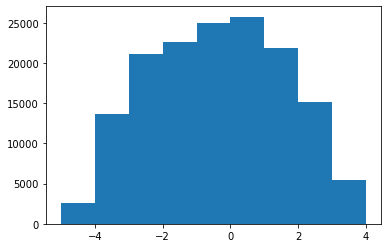

In [9]:
plt.hist(np.log10(t['spire_250']),bins=np.arange(-5,5));